<h2 style='text-align:center;'>💰 CryptoAI</h2>
<p style='text-align:center;'><em>Forecasting Bitcoin Close Price using Previous-Day Multi-Asset Signals</em></p>

**What you'll find here**
1. Load & clean the dataset (repo-relative paths)
2. Quick EDA (stats, BTC trend, correlation heatmap)
3. Feature engineering with previous-day signals for BTC/ETH/USDT
4. Time-based split (avoid leakage)
5. Train several regressors (Linear, RandomForest, optional XGBoost/LightGBM)
6. Evaluate with MAE, RMSE, R² and save artifacts
7. Export best full pipeline (scaler + model) for the Streamlit app
8. Plot actual vs predicted and save to `results/plots/`


### 📦 Imports & Paths
We keep paths **repo-relative** so the notebook runs anywhere in the project without edits.

In [1]:
import warnings; warnings.filterwarnings('ignore')
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Optional boosters (not required to run) — guarded imports
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

import joblib

# Paths
BASE_DIR = Path.cwd().resolve()
DATA_PATH = (BASE_DIR / '../data/crypto_data_updated_13_november.csv').resolve()
APP_MODELS_DIR = (BASE_DIR / '../app/models').resolve()
RESULTS_DIR = (BASE_DIR / '../results').resolve()
PLOTS_DIR = RESULTS_DIR / 'plots'
APP_MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
DATA_PATH, APP_MODELS_DIR, RESULTS_DIR

(WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/03_CryptoAI/data/crypto_data_updated_13_november.csv'),
 WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/03_CryptoAI/app/models'),
 WindowsPath('C:/Users/MUBASSHIR/OneDrive/Desktop/FSDS_TASKS/Machine_Learning/ML_Projects/03_CryptoAI/results'))

### 📊 Load & Inspect Data
We load the dataset that aggregates **BTC/ETH/USDT/BNB close & volume** series.
Ensure the **Date** column is parsed and set as index.

In [2]:
df_raw = pd.read_csv(DATA_PATH)
display(df_raw.head())
df_raw.info()

,Date,Close (BTC),Volume (BTC),Close (ETH),Volume (ETH),Close (USDT),Volume (USDT),Close (BNB),Volume (BNB)
0,2017-11-13 00:00:00+00:00,6559.490234,6263249920,316.716003,1041889984,1.00935,767884032,1.68662,12238800
1,2017-11-14 00:00:00+00:00,6635.750000,3197110016,337.631012,1069680000,1.00683,429857984,1.59258,7829600
2,2017-11-15 00:00:00+00:00,7315.540039,4200880128,333.356995,722665984,1.00318,449671008,1.53045,7615500
3,2017-11-16 00:00:00+00:00,7871.689941,5123809792,330.924011,797254016,1.00212,650278976,1.57792,8928640
4,2017-11-17 00:00:00+00:00,7708.990234,4651670016,332.394012,621732992,1.00139,639398016,1.51036,8508840


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1827 non-null   object 
 1   Close (BTC)    1827 non-null   float64
 2   Volume (BTC)   1827 non-null   int64  
 3   Close (ETH)    1827 non-null   float64
 4   Volume (ETH)   1827 non-null   int64  
 5   Close (USDT)   1827 non-null   float64
 6   Volume (USDT)  1827 non-null   int64  
 7   Close (BNB)    1827 non-null   float64
 8   Volume (BNB)   1827 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 128.6+ KB


### 🧽 Cleaning & Alignment
- Parse dates and set index
- Sort by date, drop duplicates
- Drop rows with missing values **after** all joins (strict approach for a clean baseline)

> If your CSV already has a DatetimeIndex, we coerce and sort to be safe.

In [3]:
df = df_raw.copy()
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')
else:
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

df = df.drop_duplicates()
display(df.describe(include='all'))
df.shape

,Close (BTC),Volume (BTC),Close (ETH),Volume (ETH),Close (USDT),Volume (USDT),Close (BNB),Volume (BNB)
count,1827.000000,1.827000e+03,1827.000000,1.827000e+03,1827.000000,1.827000e+03,1827.000000,1.827000e+03
mean,20228.315369,2.630272e+10,1129.229883,1.308885e+10,1.001606,4.156009e+10,143.886168,9.717711e+08
std,17028.454586,1.995516e+10,1203.999710,1.086878e+10,0.005771,3.842981e+10,184.167061,1.452963e+09
min,3236.761719,2.923670e+09,84.308296,6.217330e+08,0.966644,4.298580e+08,1.510360,9.284000e+03
25%,7666.110107,1.082725e+10,208.977219,4.495085e+09,0.999988,6.042266e+09,14.114409,1.360422e+08
50%,10793.339844,2.399141e+10,474.911011,1.095112e+10,1.000508,3.639024e+10,23.811028,3.480300e+08
75%,33734.515625,3.563229e+10,1802.761414,1.836356e+10,1.002518,6.090617e+10,293.938461,1.410656e+09
max,67566.828125,3.509679e+11,4812.087402,8.448291e+10,1.077880,2.790675e+11,675.684082,1.798295e+10


(1827, 8)

### 🔎 Quick EDA
Inspect BTC close trend and correlation among **Close** series. We keep visuals lightweight (matplotlib only).

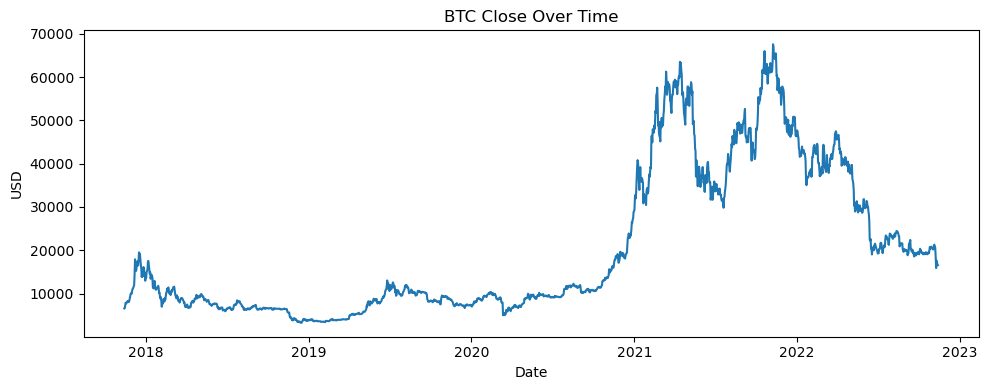

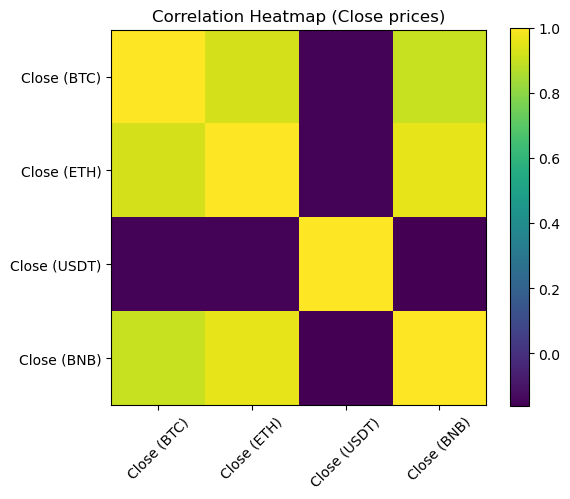

In [4]:
# Plot BTC Close over time (if present)
if 'Close (BTC)' in df.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df.index, df['Close (BTC)'])
    plt.title('BTC Close Over Time')
    plt.xlabel('Date'); plt.ylabel('USD')
    plt.tight_layout(); plt.show()

# Correlation heatmap for Close columns only
close_cols = [c for c in df.columns if 'Close' in c]
if len(close_cols) >= 2:
    corr = df[close_cols].corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.title('Correlation Heatmap (Close prices)')
    plt.xticks(range(len(corr)), corr.columns, rotation=45)
    plt.yticks(range(len(corr)), corr.index)
    plt.colorbar(); plt.tight_layout(); plt.show()

### 🧩 Feature Engineering (Previous-Day Signals)
Per your feature plan, we use **previous-day** values to predict **today's BTC close**:
- `BTC_Close_prev`, `BTC_Volume_prev`
- `ETH_Close_prev`, `ETH_Volume_prev`
- `USDT_Close_prev`, `USDT_Volume_prev`

Target: `Target_BTC_Close = Close (BTC)` (today)

> We create shifted features by 1 day and drop rows with missing values introduced by shifting.

In [5]:
required_cols = {
    'Close (BTC)': 'BTC_Close_prev',
    'Volume (BTC)': 'BTC_Volume_prev',
    'Close (ETH)': 'ETH_Close_prev',
    'Volume (ETH)': 'ETH_Volume_prev',
    'Close (USDT)': 'USDT_Close_prev',
    'Volume (USDT)': 'USDT_Volume_prev'
}

missing = [c for c in required_cols.keys() if c not in df.columns]
if missing:
    print('⚠️ Missing expected columns:', missing)

df_fe = df.copy()
for col, new_name in required_cols.items():
    if col in df_fe.columns:
        df_fe[new_name] = df_fe[col].shift(1)

df_fe['Target_BTC_Close'] = df_fe['Close (BTC)'] if 'Close (BTC)' in df_fe.columns else np.nan

# Drop rows with NaNs introduced by shifting
df_fe = df_fe.dropna(subset=list(required_cols.values()) + ['Target_BTC_Close']).copy()
df_fe.shape

(1826, 15)

### ✂️ Build X/y and Time-Based Split
We use the first 80% of records for training and the last 20% for testing to simulate future predictions.

In [6]:
feature_cols = list(required_cols.values())
X = df_fe[feature_cols]
y = df_fe['Target_BTC_Close']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train.shape, X_test.shape

((1460, 6), (366, 6))

### 🤖 Train & Evaluate Models
We compare a few baseline regressors. For consistency, we wrap them with `StandardScaler`. Tree models don't strictly require scaling, but including a scaler keeps the pipeline consistent.

In [7]:
models = {
    'LinearRegression': make_pipeline(StandardScaler(with_mean=False), LinearRegression()),
    'RandomForest': make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor(random_state=42)),
}
if HAS_XGB:
    models['XGBoost'] = make_pipeline(StandardScaler(with_mean=False), 
                                      XGBRegressor(random_state=42, n_estimators=400))
if HAS_LGBM:
    models['LightGBM'] = make_pipeline(StandardScaler(with_mean=False), 
                                       lgb.LGBMRegressor(random_state=42))

results = []
preds = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 6
[LightGBM] [Info] Start training from score 17042.546026


,Model,MAE,RMSE,R2
0,LinearRegression,801.965772,1187.434983,0.990459
3,LightGBM,1270.411155,1656.416583,0.981434
1,RandomForest,1347.735071,1668.326868,0.981166
2,XGBoost,1728.215079,2140.249054,0.969004


### 🏆 Pick Best & Save Artifacts
We select the top model by R², export the full **pipeline** to `app/models/best_model.pkl`, and store metrics + sample predictions for documentation.

In [8]:
# Save evaluation table & metrics
results_df.to_csv(RESULTS_DIR / 'metrics_table.csv', index=False)
best = results_df.iloc[0].to_dict()
with open(RESULTS_DIR / 'metrics.json', 'w') as f:
    json.dump({k: (float(v) if isinstance(v, (int, float, np.floating)) else v) for k, v in best.items()}, f, indent=2)

# Save example predictions from the best model
best_name = best['Model']
best_pipe = models[best_name]
y_pred_best = preds[best_name]
example = pd.DataFrame({'y_true': y_test.values, 'y_pred': y_pred_best}, index=y_test.index)
example.head(50).to_csv(RESULTS_DIR / 'example_predictions.csv', index=True)

# Export full pipeline for the app
joblib.dump(best_pipe, APP_MODELS_DIR / 'best_model.pkl')
best_name

'LinearRegression'

### 📈 Visualize Actual vs Predicted (Best Model)
A simple line plot to compare the best model's predictions with actual values on the test set.

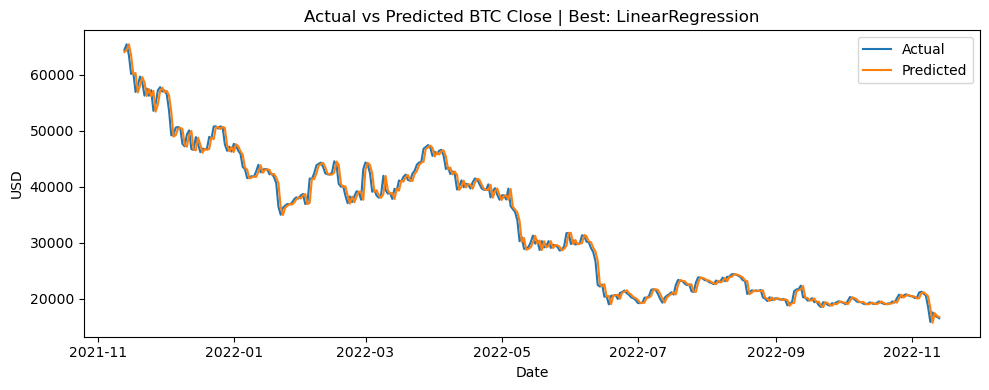

In [9]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred_best, label='Predicted')
plt.title(f'Actual vs Predicted BTC Close | Best: {best_name}')
plt.xlabel('Date'); plt.ylabel('USD'); plt.legend()
plt.tight_layout(); plt.show()

# Save figure
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred_best, label='Predicted')
plt.title(f'Actual vs Predicted BTC Close | Best: {best_name}')
plt.xlabel('Date'); plt.ylabel('USD'); plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'actual_vs_predicted.png', dpi=150)
plt.close()

### ✅ Conclusion & Next Steps
- Built a **leakage-safe**, time-aware baseline for BTC close prediction using previous-day multi-asset signals.
- Saved the best **full pipeline** for deployment in Streamlit: `app/models/best_model.pkl`.
- Stored metrics, predictions, and plots in `results/`.

**Ideas to improve:**
- Add more features: technical indicators (RSI, MACD), rolling stats.
- Try target as **t+1 returns** and reconstruct price.
- Hyperparameter tuning with `TimeSeriesSplit`.
- Enrich with external signals (funding rates, fear & greed, macro data).